In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from io import open
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
import time

In [2]:
from dataset import Step2_DataSet
from time_series_models import GRUSeq2SeqWithAttention, TimeSeriesModel, SequenceDataset

In [3]:
import kgml_lib

In [4]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [5]:
def Z_norm(X):
    X_mean=X.mean(dtype=np.float32)
    X_std=X.std(dtype=np.float32)
    return (X-X_mean)/X_std, X_mean, X_std

def Z_norm_reverse(X,Xscaler,units_convert=1.0):
    return (X*Xscaler[1]+Xscaler[0])*units_convert

In [6]:
root_dir = 'E:/PyKGML/deposit_code_v2/'
# data_path = root_dir +  'processed_data/N2O_data/'
output_path = root_dir + 'test_results/'
input_data = 'input16_output5_finetune_augmented.sav' 
y_augment_mask = 'input16_output5_finetune_augmentation_Ymask.sav' # Augment data mask

# input_data = 'input16_output5_finetune.sav'

data_path = root_dir +  'processed_data/N2O_data/' + input_data
output_path = root_dir + 'test_results/'

data0=torch.load(data_path, weights_only=False)
scaler_data = torch.load(root_dir + 'processed_data/N2O_data/' + 'input16_output5_scalers.sav', weights_only=False)
y_argu_mask = torch.load(root_dir + 'processed_data/N2O_data/' + y_augment_mask, weights_only=False)

In [7]:
data0.shape, scaler_data.shape, y_argu_mask.shape

((6, 366000, 21), (21, 2), (6, 366000, 5))

In [8]:
def plot_features(data, feature_number, feature_name, sub_title):
    n_features = feature_number 
    
    n_cols = 4
    n_rows = math.ceil(n_features / n_cols)
    
    fig = plt.figure(figsize=(4 * n_cols, 3 * n_rows))
    # plt.figure(figsize=(15, 10))
    # plt.title('Scaled Input features')
    # Loop through each feature and create a histogram subplot
    for i in range(n_features):
        plt.subplot(n_rows, n_cols, i+1)  # Adjust grid (3 rows, 4 columns) as needed
        plt.hist(data[:, i], bins=30, edgecolor='black', alpha=0.7)
        # plt.title(f'Feature {i+1}')
        _f_name = feature_name[i] 
        plt.title(_f_name)
        # plt.xlabel(_f_name)
        plt.ylabel('Frequency')
    
    # plt.tight_layout()
    # Add a main title for all subplots
    # Set a suptitle with a lower y value to bring it closer to subplots
    # positions the overall title at 92% of the figure height (you can try lowering this value further if needed).
    # plt.suptitle("Distribution of Scaled Features", fontsize=16, y=0.95)
    plt.suptitle(sub_title, fontsize=16)
    
    # Adjust subplots: increase the 'top' value to reduce the gap between the title and subplots.
    # plt.subplots_adjust(top=0.92, hspace=0.5)
    
    # Adjust the vertical space between rows (hspace)
    # plt.subplots_adjust(hspace=0.4)  # Increase or decrease 0.5 as needed

    # Reserve space at the top (e.g., 5% margin) so the suptitle doesn't overlap
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()
    fig.savefig("my_plot.png", dpi=300, bbox_inches="tight")

In [9]:
# Get output features' scaler values: [Mean, Std]
y_data = data0[...,16:]
y_scaler = []
for i in range(5):
    _data = y_data[...,i].reshape(-1)
    _mean = _data.mean()
    _std  = _data.std()
    y_scaler.append([_mean, _std])
y_scaler = np.array(y_scaler)

In [10]:
y_scaler.shape

(5, 2)

In [15]:
# Z_norm for 5 output features

# 1) Extract means and stds as 1D arrays of length 5:
means = y_scaler[:, 0]  # shape (5,)
stds  = y_scaler[:, 1]  # shape (5,)

# 2) Pull out shape info
n_runs, n_samples, n_feats = data0.shape  # -> 6, 366000, 21

# 3) Flatten the first two dims so we have a 2D array: (6*1000, 21)
flat = data0.reshape(-1, n_feats)         # shape = (6000, 21)

# 4) Z-normalize each column (5 features) in one vectorized step:
flat[:, -5:] = (flat[:, -5:] - means) / stds

# 5) Un-flatten back to (6, 1000, 21)
data_scaled = flat.reshape(n_runs, n_samples, n_feats)

In [16]:
input_features = ['FERTZR_N', 'RADN', 'TMAX_AIR', 'TMIN_AIR', 'HMAX_AIR', 'HMIN_AIR', 'WIND', 'PRECN', 'PDOY', 'PLANTT', 'TBKDS', 'TCSAND', 'TCSILT', 'TPH', 'TCEC', 'TSOC']
output_features = ['N2O_FLUX', 'CO2_FLUX', 'WTR_3', 'NH4_3', 'NO3_3']
features = input_features + output_features

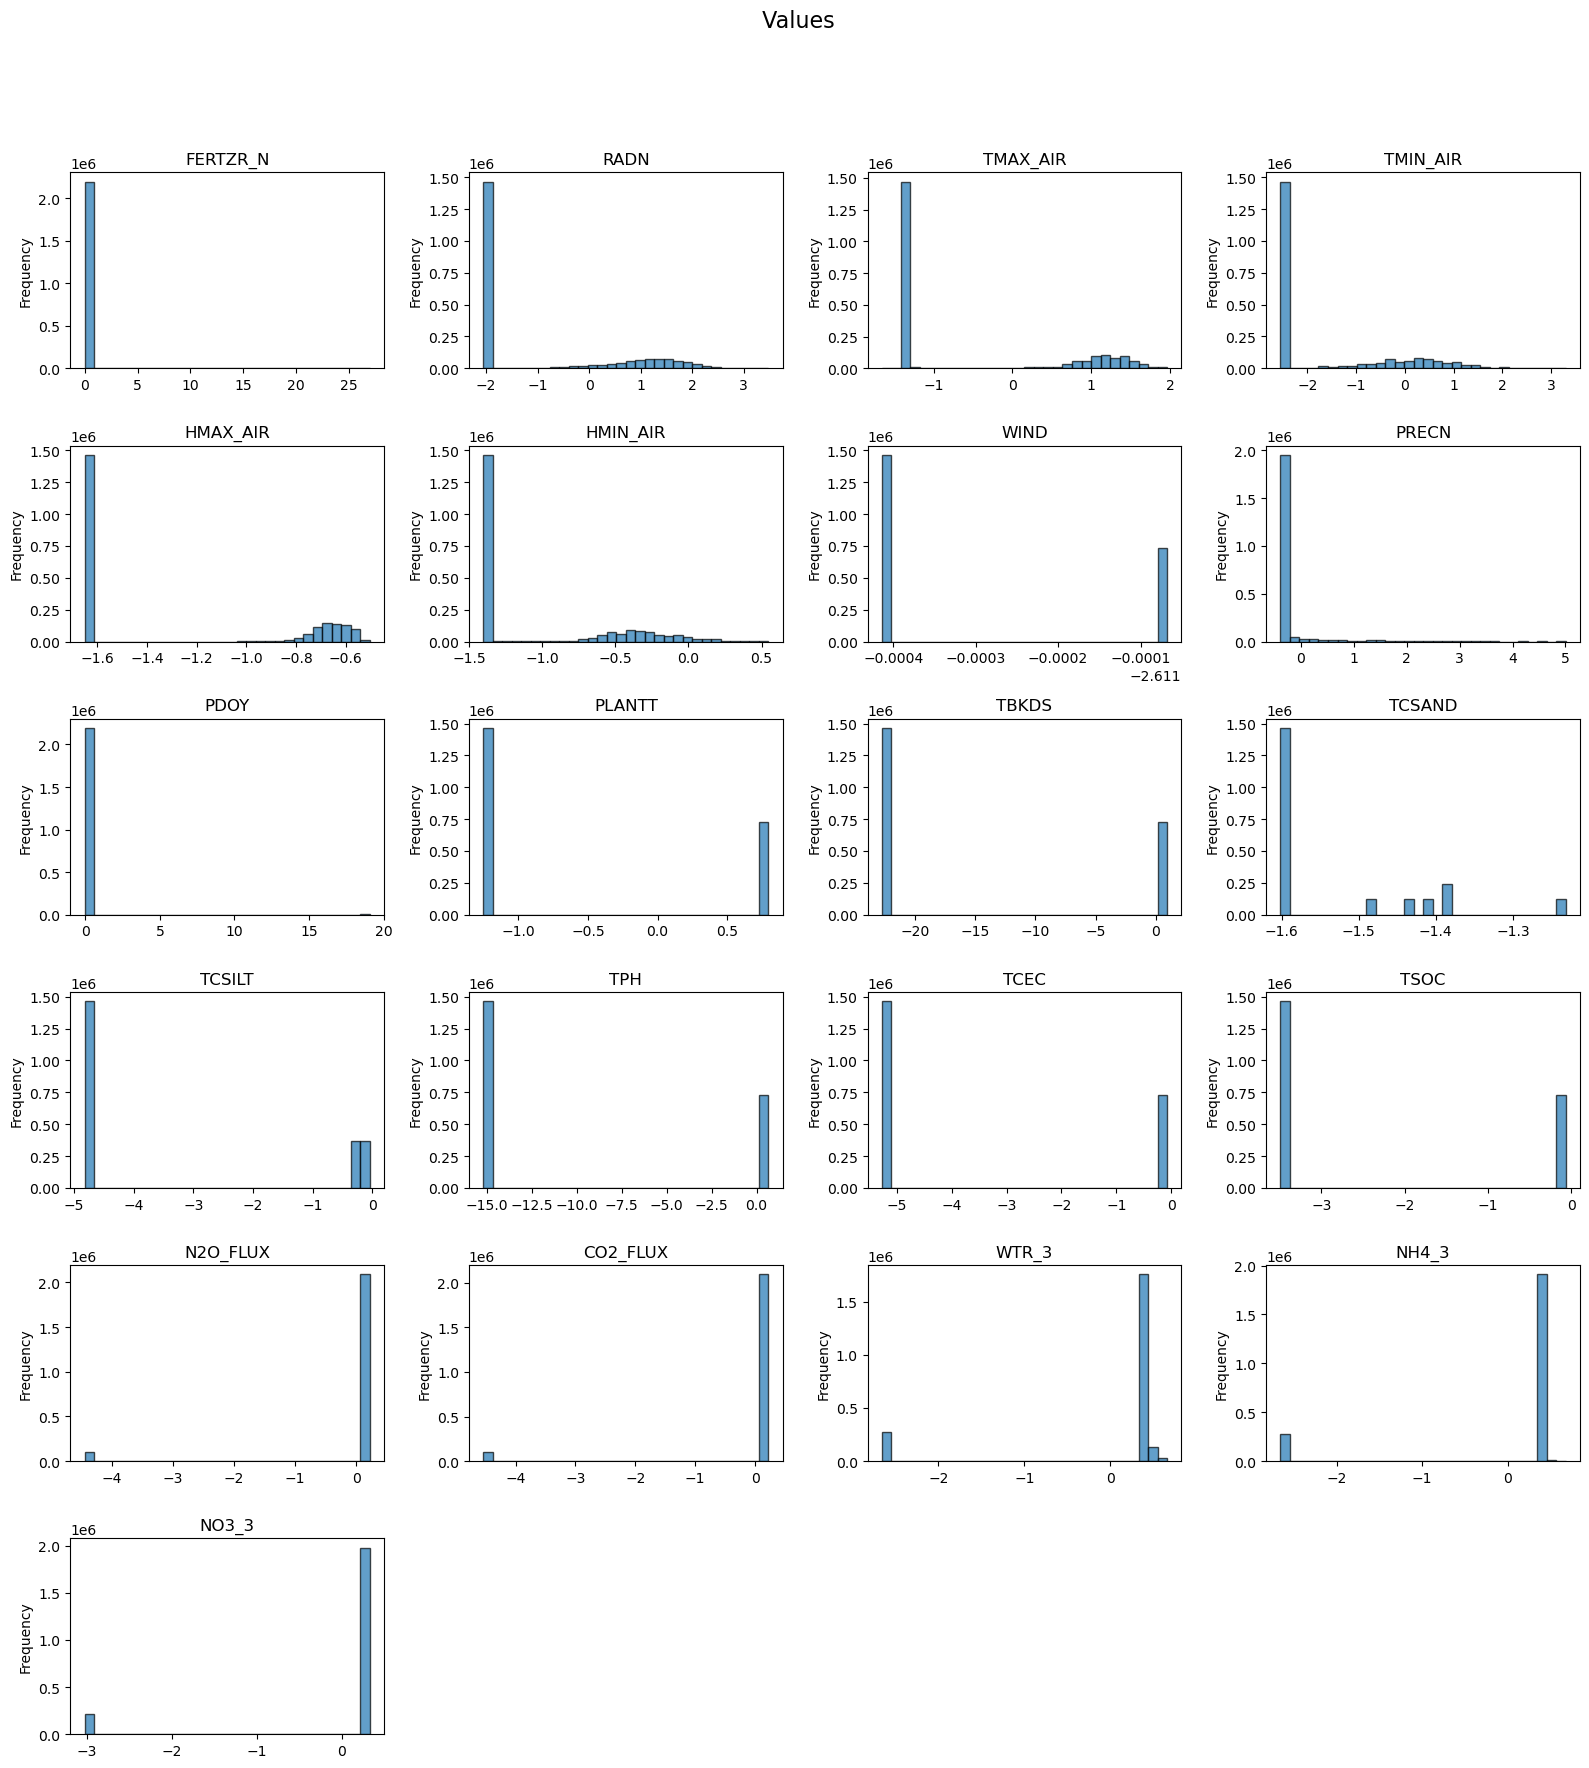

In [17]:
values = data_scaled.reshape(-1, 21)
sub_title = " Values"
plot_features(values, 21, features, sub_title)

In [18]:
# Add Mask to whole dataset
data_with_mask = np.concatenate((data_scaled, y_argu_mask), axis=2)
data_with_mask.shape

(6, 366000, 26)

In [19]:
# Shuffle the site order
site_num = data_with_mask.shape[0]
site_random_list = np.random.choice(site_num, size=site_num, replace=False) # without replacement
site_random_list

array([0, 3, 5, 1, 4, 2], dtype=int32)

In [20]:
# pickup last two sites as test
train_site = site_random_list[:4]
test_site = site_random_list[4:]

In [21]:
# Split input features and output features and masks
X_train = data_with_mask[train_site,:, :16]
Y_train = data_with_mask[train_site,:, 16:]

X_test = data_with_mask[test_site,:, :16]
Y_test = data_with_mask[test_site,:, 16:]

In [22]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((4, 366000, 16), (2, 366000, 16), (4, 366000, 10), (2, 366000, 10))

In [23]:
# Set parameters for create a Module
num_input_features = 16
num_output_features = 5

input_dim = num_input_features
hidden_dim = 128
num_layers = 5
output_dim = num_output_features
dropout=0.2

In [24]:
model = GRUSeq2SeqWithAttention(input_dim, hidden_dim, num_layers, output_dim, dropout)

In [25]:
# Create Pytorch dataloader
sequence_length = 1000  # Use one day's consecutive records as a sample

# Create Dataset objects for training and testing.
train_dataset = SequenceDataset(X_train, Y_train, sequence_length)
test_dataset = SequenceDataset(X_test, Y_test, sequence_length)

# Create DataLoaders.
batch_size = 16
model.train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
model.test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [26]:
learning_rate = 0.001
step_size = 40
max_epoch = 200
gamma = 0.8
loss_function = nn.L1Loss() #nn.MSELoss()

# Need use the masks when calculate loss
model.train_model(loss_fun=loss_function, LR= learning_rate, step_size= step_size, gamma=0.8, maxepoch=max_epoch, use_y_mask =True)

Epoch 1/200 | LR: 0.001000, Train Loss: 0.0079, Test Loss: 0.0028
Epoch 2/200 | LR: 0.001000, Train Loss: 0.0039, Test Loss: 0.0033
Epoch 3/200 | LR: 0.001000, Train Loss: 0.0036, Test Loss: 0.0029
Epoch 4/200 | LR: 0.001000, Train Loss: 0.0033, Test Loss: 0.0030
Epoch 5/200 | LR: 0.001000, Train Loss: 0.0034, Test Loss: 0.0030
Epoch 6/200 | LR: 0.001000, Train Loss: 0.0033, Test Loss: 0.0026
Epoch 7/200 | LR: 0.001000, Train Loss: 0.0032, Test Loss: 0.0026
Epoch 8/200 | LR: 0.001000, Train Loss: 0.0031, Test Loss: 0.0029
Epoch 9/200 | LR: 0.001000, Train Loss: 0.0031, Test Loss: 0.0027
Epoch 10/200 | LR: 0.001000, Train Loss: 0.0031, Test Loss: 0.0030
Epoch 11/200 | LR: 0.001000, Train Loss: 0.0031, Test Loss: 0.0028
Epoch 12/200 | LR: 0.001000, Train Loss: 0.0029, Test Loss: 0.0026
Epoch 13/200 | LR: 0.001000, Train Loss: 0.0029, Test Loss: 0.0025
Epoch 14/200 | LR: 0.001000, Train Loss: 0.0029, Test Loss: 0.0027
Epoch 15/200 | LR: 0.001000, Train Loss: 0.0029, Test Loss: 0.0026
Epoc

In [27]:
model.test(use_y_mask=True)

Test Loss: 0.0015


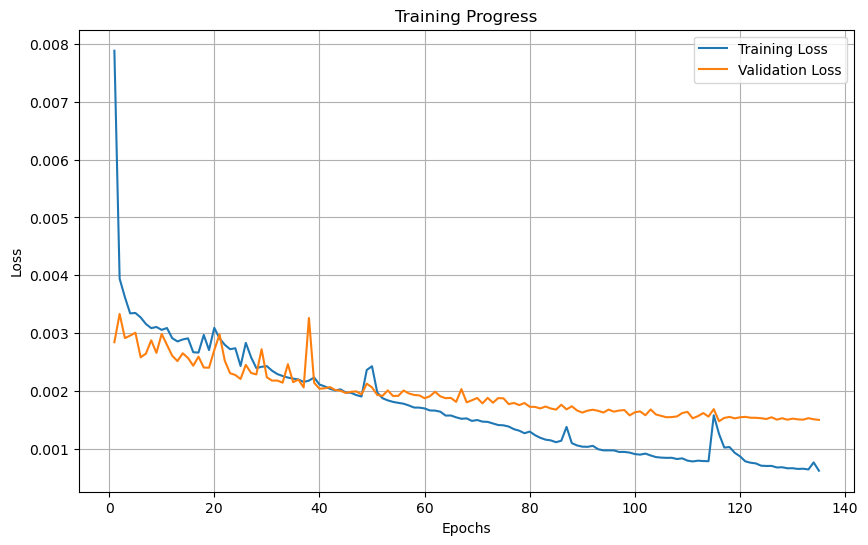

In [28]:
model.plot_training_curves()

In [29]:
model.get_R2_score(y_scaler, output_features)

Feature N2O_FLUX R2 Score is: 0.9999975687983645
Feature CO2_FLUX R2 Score is: 0.9997775871689961
Feature WTR_3 R2 Score is: 0.9892171952759168
Feature NH4_3 R2 Score is: 0.9954242578056296
Feature NO3_3 R2 Score is: 0.9999992576162903


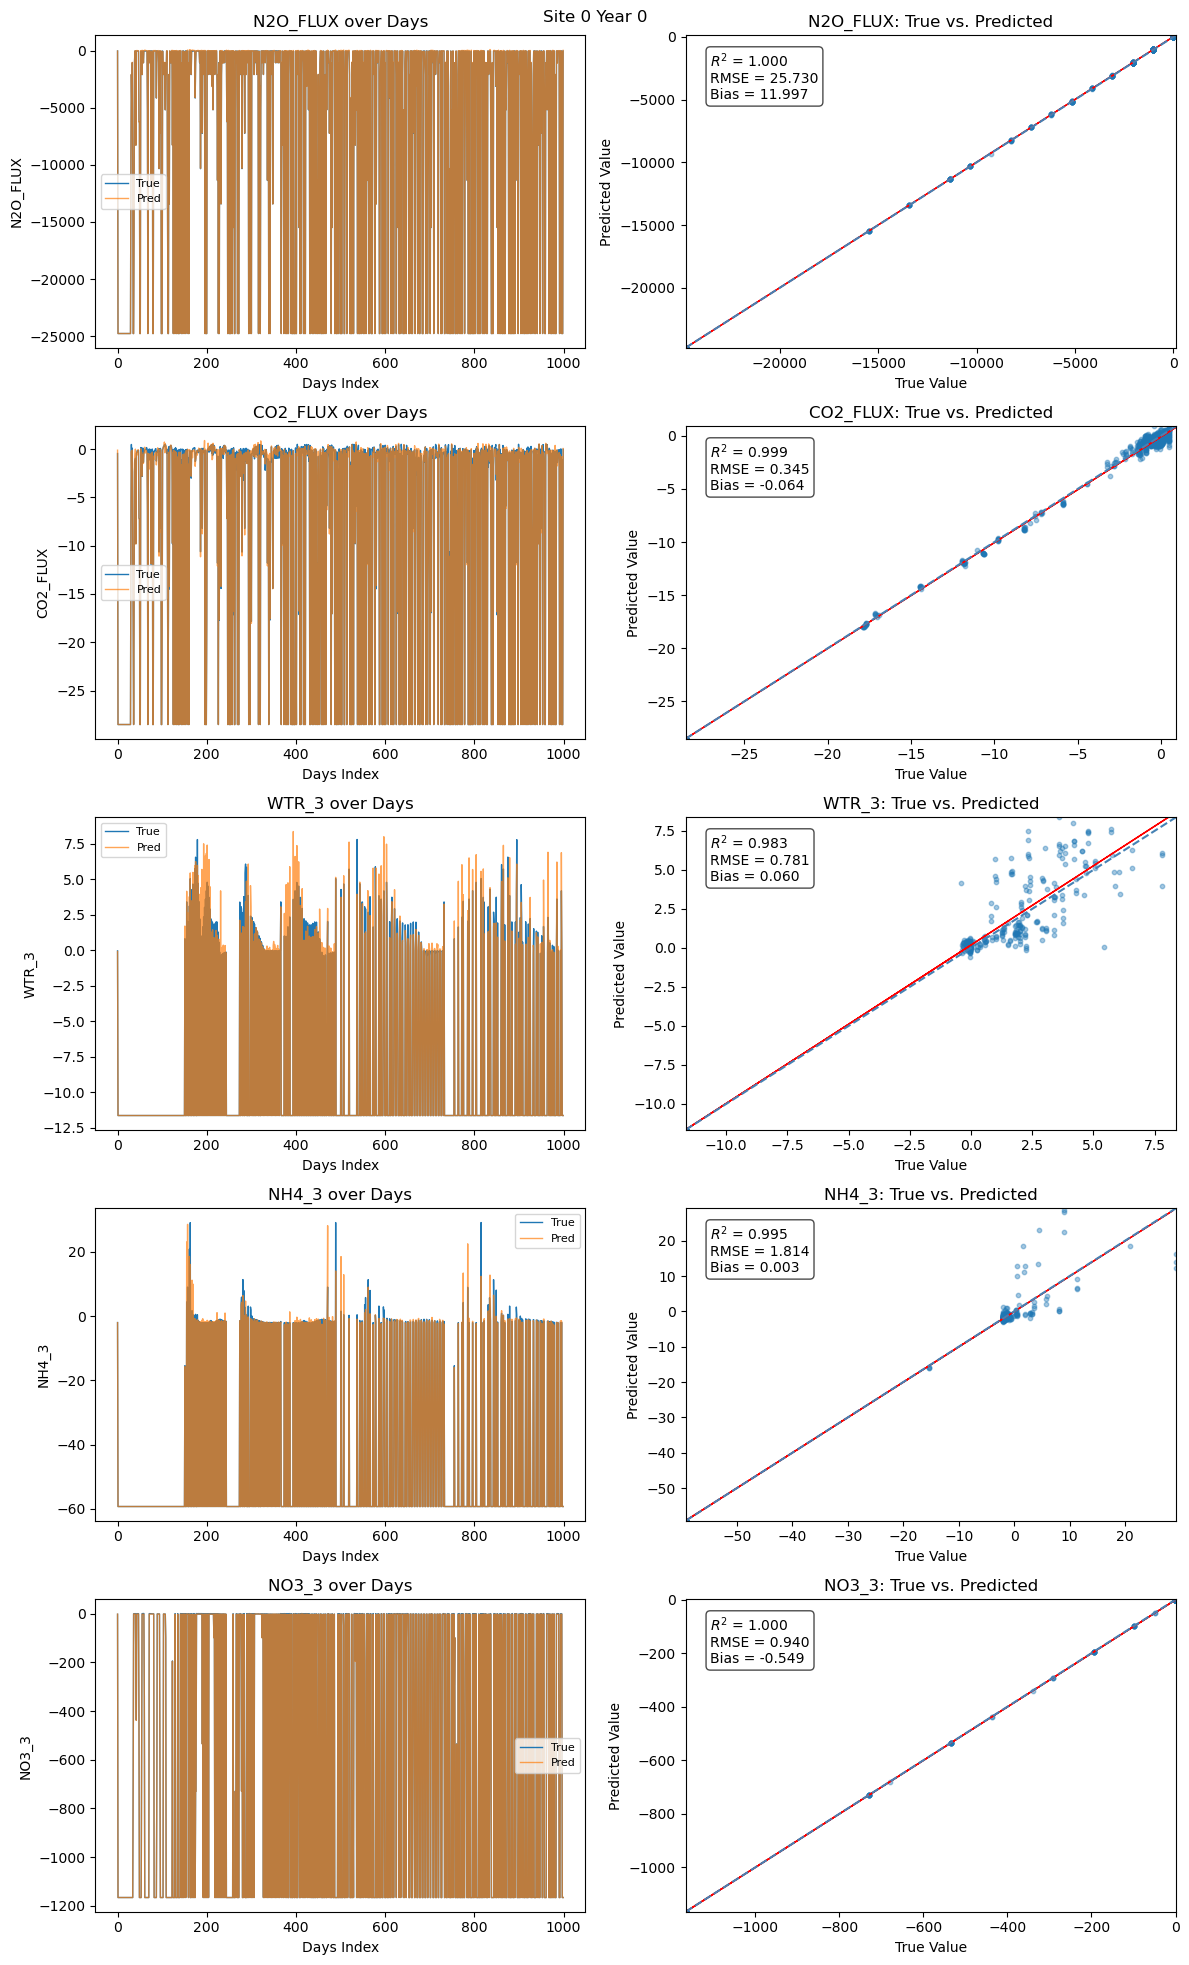

In [30]:
model.Vis_prediction_result(y_scaler, output_features, site=0, year=0)